In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
df = pd.read_csv('tweets-2023.csv')
df['created_at'] = pd.to_datetime(df['created_at'])
df

,created_at,full_text
0,2023-01-01 04:30:30+00:00,Condom crisis: Busia sex workers recycle condo...
1,2023-01-01 04:47:16+00:00,Cause we know crying doesn t solve the problem...
2,2023-01-01 06:42:04+00:00,Obviously it s bad for your health but it s al...
3,2023-01-01 06:42:05+00:00,Vapes can take hundreds of years to degrade. T...
4,2023-01-01 09:48:10+00:00,Aluminium crushing: If the manufacturer finds ...
...,...,...
9880,2023-12-30 22:27:09+00:00,Pilots are being paid per pound of industrial ...
9881,2023-12-30 22:59:50+00:00,toxic waste ain't that sour tbh
9882,2023-12-30 23:00:32+00:00,This eye-opening ArcGIS StoryMap provides an o...
9883,2023-12-30 23:35:08+00:00,There is no situation where not giving up is t...


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9885 entries, 0 to 9884
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   created_at  9885 non-null   datetime64[ns, UTC]
 1   full_text   9885 non-null   object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 154.6+ KB


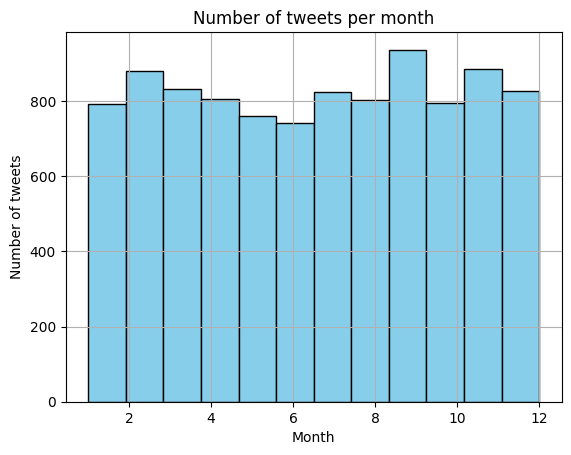

In [28]:
df['created_at'].dt.month.hist(bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of tweets')

plt.title('Number of tweets per month')
plt.show()

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [30]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'POS'

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

device

device(type='cuda')

In [39]:
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return model.config.id2label[predicted_class_id]

In [35]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove mentions (@username) and hashtags (#hashtag)
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

In [36]:
sentiment_map = {
    "NEG": "Negative",
    "NEU": "Neutral",
    "POS": "Positive"
}

In [40]:
df['cleaned_text'] = df['full_text'].apply(clean_text)
df['sentiment'] = df['cleaned_text'].apply(get_sentiment)
df['sentiment'] = df['sentiment'].map(sentiment_map)
df

,created_at,full_text,cleaned_text,sentiment
0,2023-01-01 04:30:30+00:00,Condom crisis: Busia sex workers recycle condo...,condom crisis busia sex workers recycle condom...,Neutral
1,2023-01-01 04:47:16+00:00,Cause we know crying doesn t solve the problem...,cause know crying solve problem gotta stay sol...,Negative
2,2023-01-01 06:42:04+00:00,Obviously it s bad for your health but it s al...,obviously bad health also terrible environment...,Negative
3,2023-01-01 06:42:05+00:00,Vapes can take hundreds of years to degrade. T...,vapes take hundreds years degrade break microp...,Negative
4,2023-01-01 09:48:10+00:00,Aluminium crushing: If the manufacturer finds ...,aluminium crushing manufacturer finds issue pr...,Negative
...,...,...,...,...
9880,2023-12-30 22:27:09+00:00,Pilots are being paid per pound of industrial ...,pilots paid per pound industrial waste spread ...,Negative
9881,2023-12-30 22:59:50+00:00,toxic waste ain't that sour tbh,toxic waste aint sour tbh,Negative
9882,2023-12-30 23:00:32+00:00,This eye-opening ArcGIS StoryMap provides an o...,eyeopening arcgis storymap provides overview c...,Neutral
9883,2023-12-30 23:35:08+00:00,There is no situation where not giving up is t...,situation giving toxic like queue play play le...,Negative


In [41]:
df.to_csv('tweets-2023-sentiment.csv', index=False)

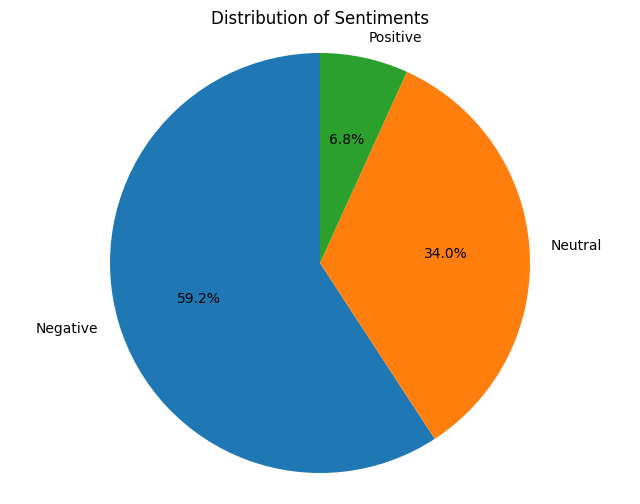

In [42]:
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sentiments')
plt.axis('equal')
plt.show()